In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models,layers

In [2]:
## Download data from kaggle

# import kagglehub

# Download latest version
# path = kagglehub.dataset_download("emmarex/plantdisease")

# print("Path to dataset files:", path)

In [20]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCH = 5    

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            "PotatoDataset/",
            shuffle=True,
            image_size = (IMAGE_SIZE,IMAGE_SIZE),
            batch_size = BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [10]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

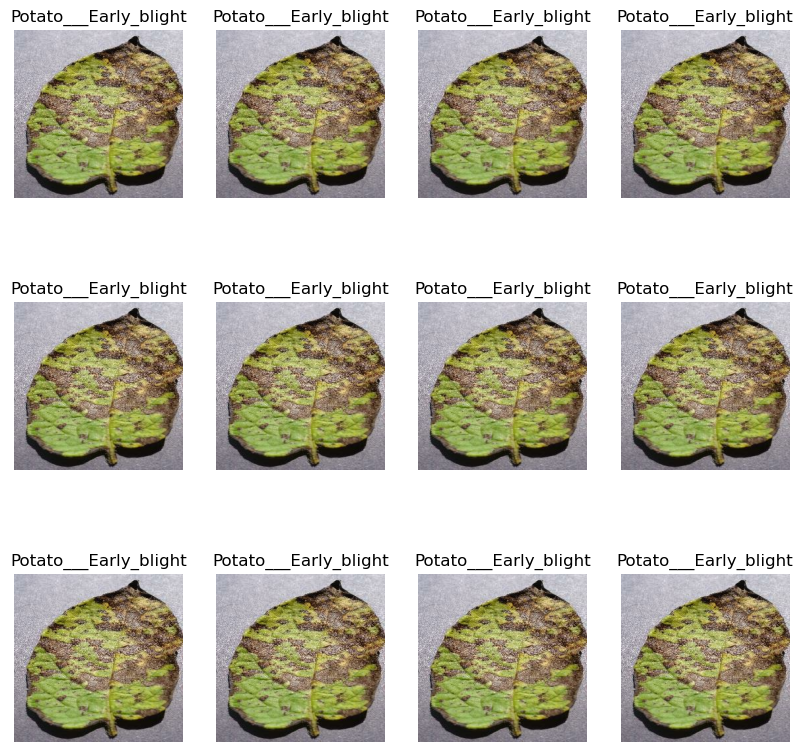

In [18]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype('uint8'))
        plt.title(class_name[label_batch[0]])
        plt.axis('off')

In [19]:
len(dataset)

68

In [21]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [26]:
train_ds = dataset.take(int(len(dataset)*train_size))
len(train_ds)

54

In [27]:
test_ds = dataset.skip(int(len(dataset)*train_size))
len(test_ds)

14

In [28]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1, shuffle=True):
    train_size = int(len(dataset)*train_split)
    val_size = int(len(dataset)*val_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [29]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [32]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In [33]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [35]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [36]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [38]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3


model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')

])


model.build(input_shape = input_shape)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy']
             )

In [42]:
history = model.fit(train_ds,
                     epochs=EPOCH,
                     batch_size=BATCH_SIZE,
                     verbose=1,
                     validation_data=val_ds
                   )

Epoch 1/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 432ms/step - accuracy: 0.4318 - loss: 0.9763 - val_accuracy: 0.4740 - val_loss: 0.8764
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 437ms/step - accuracy: 0.5533 - loss: 0.8518 - val_accuracy: 0.7344 - val_loss: 0.6218
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 432ms/step - accuracy: 0.7251 - loss: 0.5877 - val_accuracy: 0.7865 - val_loss: 0.3800
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 448ms/step - accuracy: 0.8276 - loss: 0.4197 - val_accuracy: 0.8906 - val_loss: 0.2894
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 454ms/step - accuracy: 0.8793 - loss: 0.3355 - val_accuracy: 0.8802 - val_loss: 0.2784


In [44]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.8704 - loss: 0.3047


In [45]:
scores

[0.3632037937641144, 0.8706896305084229]

In [47]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [48]:
history.history

{'accuracy': [0.46643519401550293,
  0.609375,
  0.7771990895271301,
  0.8530092835426331,
  0.8663194179534912],
 'loss': [0.9316180944442749,
  0.800416111946106,
  0.5077023506164551,
  0.3716266453266144,
  0.36866289377212524],
 'val_accuracy': [0.4739583432674408,
  0.734375,
  0.7864583134651184,
  0.890625,
  0.8802083134651184],
 'val_loss': [0.8764317035675049,
  0.6217896938323975,
  0.380002498626709,
  0.28941234946250916,
  0.27842846512794495]}

In [49]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

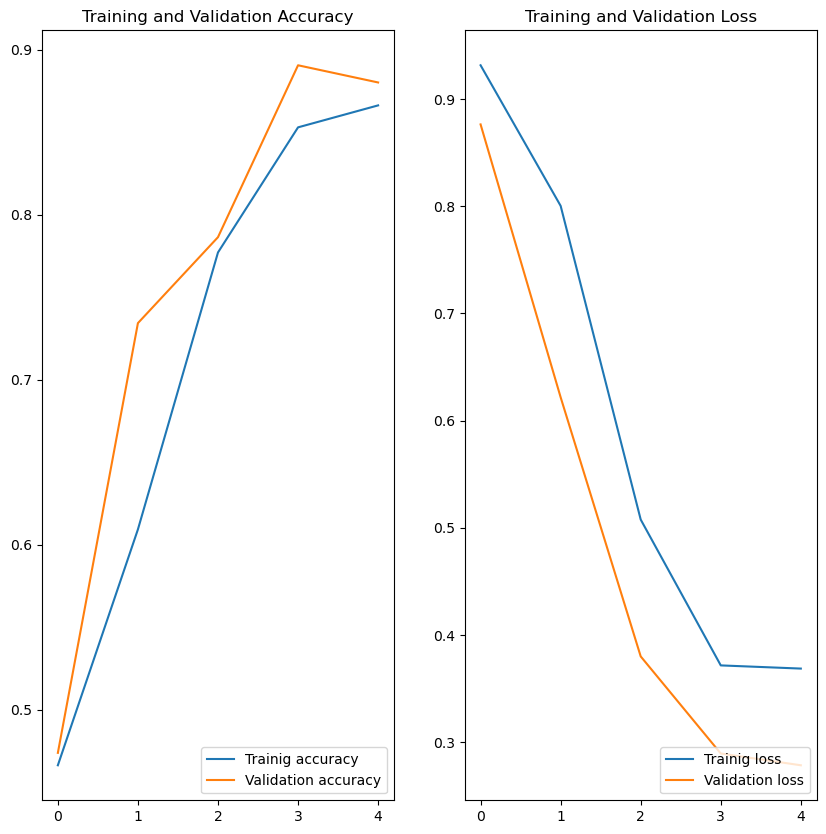

In [51]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCH),acc,label='Trainig accuracy')
plt.plot(range(EPOCH),val_acc,label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCH),loss,label='Trainig loss')
plt.plot(range(EPOCH),val_loss,label='Validation loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')


first_image
Actual label Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Predicted label Potato___Late_blight


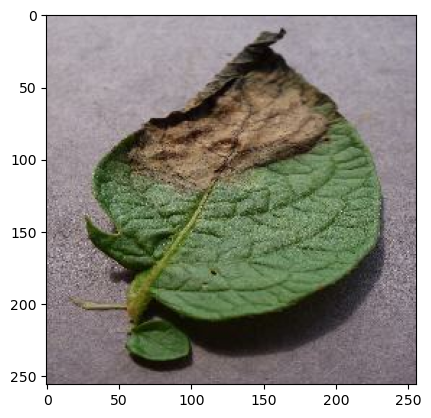

In [64]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0]
    
    print('first_image')
    plt.imshow(first_image)
    print('Actual label',class_name[first_label])
    
    
    batch_prediction = model.predict(image_batch)
    print('Predicted label',class_name[batch_prediction[0].argmax()])

In [67]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


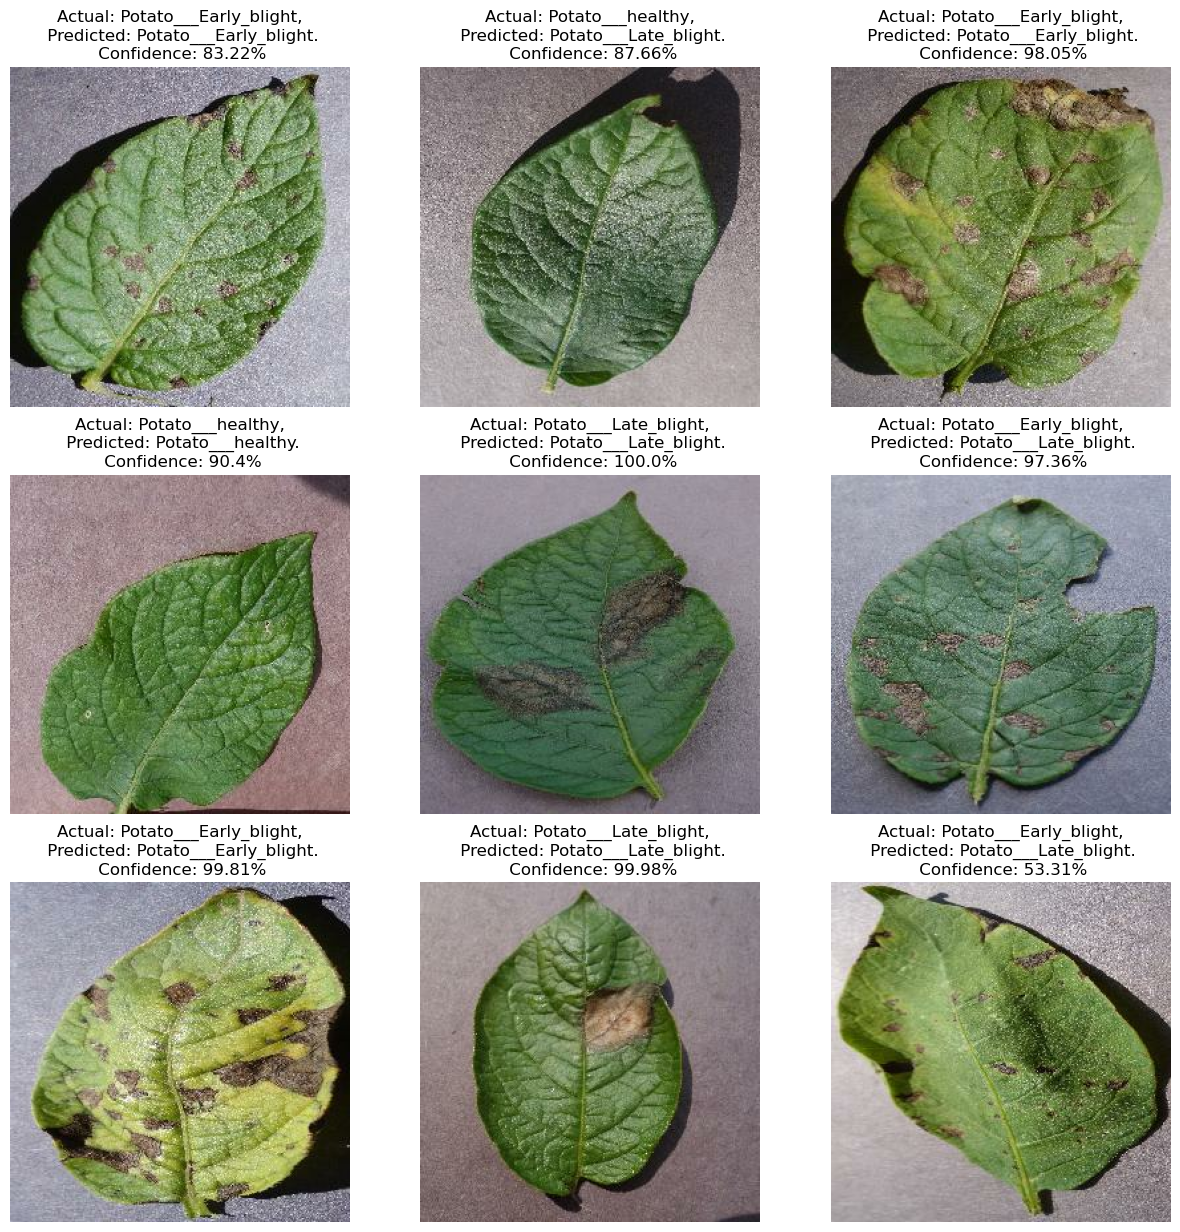

In [69]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [78]:
import os
model_version = max([int(i) for i in os.listdir('../models') + [0]])+1
model.save(f"models/version_{model_version}.h5")

FileNotFoundError: [Errno 2] No such file or directory: '../models'

In [86]:
max([int(i.split('_')[1].split('.')[0]) for i in os.listdir('models/') + [0]])+1

ValueError: invalid literal for int() with base 10: 'checkpoints'

In [83]:
os.listdir(f'models/')

['version_1.h5', '.ipynb_checkpoints']

In [87]:
[int(i.split('_')[1].split('.')[0]) for i in os.listdir('models/') + [0]]

ValueError: invalid literal for int() with base 10: 'checkpoints'

In [94]:
[i.split('_')[1].split('.')[0] for i in os.listdir('models/')]

['1', 'checkpoints']